# Body Pose Model

จากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถแสดงโครงลำตัวได้ โดยอาศัยการเรียนรู้ภาพต้นแบบสามมิติ นำมาหาค่าพิกัดที่สำคัญ เพื่อใช้แสดงผลเป็นรูปทรงเรขาคณิตจำนวน 17 พิกัด ดังรูป <br><br>

![body_pose.png](https://www.tensorflow.org/static/hub/tutorials/movenet_files/output_VHmTwACwFW-v_0.png)<br><br>

ในการวัดมุมของใบหน้าจะถูกแบ่งเป็น 4 ท่าทาง ได้แก่ ยกแขนขวา, ยกแขนซ้าย, ยกสองแขน, หุบแขน

1. **ยก / หุบ แขนขวา** ทำการวัดจุดข้อมือขวากับจุดหัวไหล่ด้านขวา (ตำแหน่งที่ 6 & 8 กับ 10) โดยวัดในระนาบทางสูงอย่างเดียว ในกรณีที่ความสูงของข้อมือ *มากกว่า* หัวไหล่ จะถูกนับว่ายกมือขวา

2. **ยก / หุบ แขนซ้าย** ทำการวัดจุดข้อมือซ้ายกับจุดหัวไหล่ด้านซ้าย (ตำแหน่งที่ 5 & 7 กับ 9) โดยวัดในระนาบทางสูงอย่างเดียว ในกรณีที่ความสูงของข้อมือ *มากกว่า* หัวไหล่ จะถูกนับว่ายกมือซ้าย

<br>

**ตัวอย่างโค้ด**ด้านล่าง จะเป็นการเขียนโปรแกรมเพื่อใช้งานตัวโมเดลจาก Mediapipe ในการทำนายท่าทาง และแสดงผลเป็นรูปภาพพร้อมจุดพิกัดและเส้นเชื่อมแสดงรูปทรงเรขาคณิตของลำตัว โดยประกอบด้วย 5 ขั้นตอนดังต่อไปนี้

**ขั้นตอนที่ 1** การเชื่อมต่อ Google Drive เพื่อค้นหารูปภาพตัวอย่างที่เก็บอยู่ใน Drive ของคุณ

In [ ]:
# Connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title Additional function for keypoints conversion
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def keypoints_conversion(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    # for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
    #   if (kpts_scores[edge_pair[0]] > keypoint_threshold and
    #       kpts_scores[edge_pair[1]] > keypoint_threshold):
    #     x_start = kpts_absolute_xy[edge_pair[0], 0]
    #     y_start = kpts_absolute_xy[edge_pair[0], 1]
    #     x_end = kpts_absolute_xy[edge_pair[1], 0]
    #     y_end = kpts_absolute_xy[edge_pair[1], 1]
    #     line_seg = np.array([[x_start, y_start], [x_end, y_end]])
    #     keypoint_edges_all.append(line_seg)
    #     edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  # if keypoint_edges_all:
  #   edges_xy = np.stack(keypoint_edges_all, axis=0)
  # else:
  #   edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy #, edges_xy, edge_colors

**ขั้นตอนที่ 2** การนำเข้าโมเดลจาก Mediapipe

In [ ]:
import requests
import os
import tensorflow as tf
import tensorflow_hub as hub

# Load the TFLite model and allocate tensors.
# Ref. https://www.tensorflow.org/hub/tutorials/movenet

# URL of the TFLite model
model_url = "https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite"

# Download the model
if not os.path.exists("body_model.tflite"):
    response = requests.get(model_url)
    open("body_model.tflite", "wb").write(response.content)

# Load the TFLite model
model = tf.lite.Interpreter(model_path="body_model.tflite")
model.allocate_tensors()

# Get input and output tensors.
input_details = model.get_input_details()
output_details = model.get_output_details()

In [170]:
import numpy as np
import cv2

# Path of the input image
image_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/body/body1.jpg"

# Load the image to predict
img = cv2.imread(image_path) # read image from path
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert an image to RGB color space
img = cv2.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][2])) # resize to match inputs of model
img = img.astype(np.uint8)

**ขั้นตอนที่ 4** ประมวลผลรูปผ่านโมเดลเพื่อทำนายจุดพิกัดสำคัญของลำตัว

In [171]:
# Pass the image and Run the model on the image
model.set_tensor(input_details[0]['index'], [img])
model.invoke()

# Get keypoints from the output
keypoints = model.get_tensor(output_details[0]['index'])
keypoints = np.squeeze(keypoints_conversion(keypoints,
                     input_details[0]['shape'][1],
                     input_details[0]['shape'][2]))

**ขั้นตอนที่ 5** แสดงผลรูปการทำนายการยกแขน

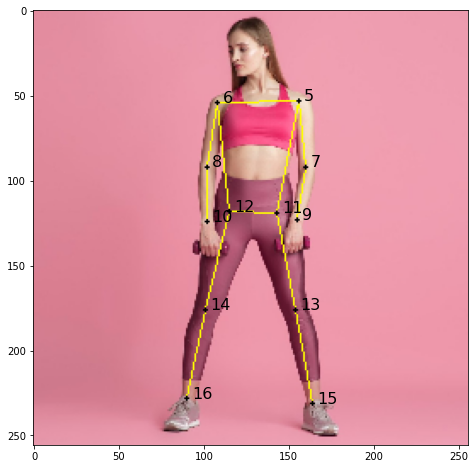

Direction of Arm: drop both arm


In [172]:
from matplotlib import pyplot as plt
import numpy as np

# Show the output image
if img[0,0,0] < 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(8, 8)) # define size of figure
plt.imshow(img) # display image in the figure

# Draw lines between keypoints
keypoints_pairs = [(5,6),(6,12),(12,11),(11,5),(5,7),(7,9),(6,8),(8,10),(12,14),(14,16),(11,13),(13,15)]
for pair in keypoints_pairs: # loop each key pair to draw line
    x1, y1 = int(keypoints[pair[0],0]), int(keypoints[pair[0],1])
    x2, y2 = int(keypoints[pair[1],0]), int(keypoints[pair[1],1])
    cv2.line(img, (x1, y1), (x2, y2), (255, 255, 0), 1) # draw a line

# # Draw keypoints on the image
for i in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    cv2.circle(img, kp, 1, (0, 0, 0), -1)

# Add text overlay on the image
for i in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    ax.annotate(i, kp, fontsize=16, xytext=(5,0), textcoords='offset points') # write text of keypoint ID

# Display the output image using matplotlib
plt.imshow(img)
plt.show()

# Arm Direction Prediction
# Define the indices for keypoints for 4 positions: left arm, right arm, left albow, right albow
left_side = "raise left" if ((keypoints[9,1] - keypoints[5,1]) < 0) or ((keypoints[9,1] - keypoints[7,1]) < 0) else "drop"
right_side = "raise right" if ((keypoints[10,1] - keypoints[6,1]) < 0) or ((keypoints[10,1] - keypoints[8,1]) < 0) else "drop"

# Summarize text
if (left_side == "raise") and (right_side == "raise"):
  text = "raise both arm"
elif (left_side == "drop") and (right_side == "drop"):
  text = "drop both arm"
elif (left_side == "drop"):
  text = right_side
else:
  text = left_side

# Print the output
print("Direction of Arm:", text)